165048.01271000013
149542.59792000015
127503.17110000012
109099.09220000013
95975.64314000012
82238.9248600001
72881.96633000013
57923.82705000012
50796.49975000007
45361.09131000006
34973.93000000001
30446.04194000011
28757.48186000007
23287.132490000025
20601.83613999998
14741.754589999977
14741.754589999977
13363.25978999997
10820.689399999967
9435.178239999945
7109.484990000006
6558.597859999977
Resultado do algoritmo genético: 4728.271579999992
Tempo de execução: 15.920064210891724 segundos


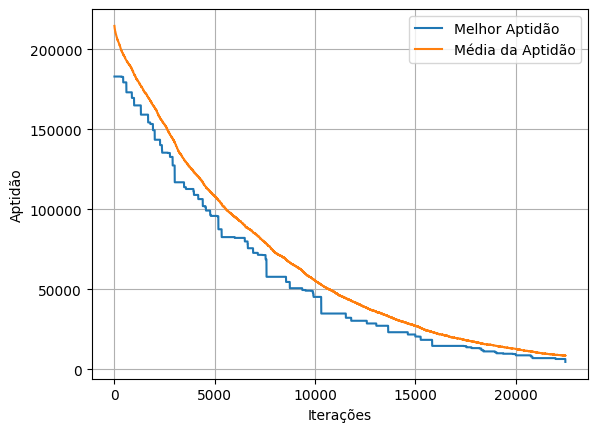

In [1]:
# Bibliotecas necessárias

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time

# Leitura dos dados

demandareal = pd.read_excel("setembro2021.xlsx")
demandareal = demandareal["CONSUMO"].values

# Parâmetros
volume_maximo = 5
volume_minimo = 2
vazao = 2
probcruz = 0.6
probmut = 0.02
num_individuals = 150

# Função objetivo a ser minimizada, com penalidade de demanda

def fitness(individuo, demanda, volume_maximo, volume_minimo, custo, vazao, check=0):
    volume = volume_maximo

    fit = np.sum(custo[individuo])
    volume_t = individuo * vazao - demanda
    volume_t = np.array([volume] + list(volume_t))
    volume_t = np.cumsum(volume_t)

    # Verifica as restrições de volume mínimo e máximo
    volume_penal = np.maximum(volume_t - volume_maximo, 0) + np.maximum(volume_minimo - volume_t, 0)

    if check == 1:
        print(volume_penal, fit, len(volume_penal))

    # Calcula a aptidão considerando as restrições
    fit += np.sum(volume_penal)
    return fit

# Definição da tarifa:

def S(t):
    hora = t % 24  # Calcula a hora do dia a partir do índice t
    if hora >= 17 and hora < 21:  # Horário de ponta
        return 1.63527
    else:  # Horário fora de ponta
        return 0.62124
        
tarifa = np.array([S(i) for i in range(len(demandareal))])

# Seleção

def selecao(populacao, aptidao):
    aid = np.random.choice(len(populacao), size=2, replace=False)
    bid = np.random.choice(len(populacao), size=2, replace=False)
    
    aid = aid[np.argmax(aptidao[aid])]
    bid = bid[np.argmax(aptidao[bid])]
    a = populacao[aid]
    b = populacao[bid]
    apt = aptidao[aid]
    bpt = aptidao[bid]
    
    return np.array([a, b]), np.array([apt, bpt])

# Cruzamento

def cruzamento(pais, probcruz):
    if np.random.rand() < probcruz:
        filho = np.empty_like(pais[0])
        for i in range(len(filho)):
            if np.random.rand() < 0.5:
                filho[i] = pais[0][i]
            else:
                filho[i] = pais[1][i]
    else:
        filho = pais[np.random.randint(0, 2)]
    
    return filho

# Mutação

def mutacao(individuo, probmut):
    n = len(individuo)
    copia = np.copy(individuo)
    num_mutacoes = int(probmut * n)
    idx = np.random.choice(n, size=num_mutacoes, replace=False)

    for i in range(num_mutacoes):
        gene = idx[i]
        novo_valor = np.random.uniform(0, 1)
        novo_gene = 0 if novo_valor <= 0.5 else 1
        copia[gene] = novo_gene

    return copia

# Algoritmo Genético

def AG(demandareal, tarifa, volume_maximo, volume_minimo, vazao, probcruz, probmut, num_individuals):
    
    np.random.seed(424)
    num_genes = len(demandareal)
    populacao = np.random.choice([True, False], size=(num_individuals, num_genes))
    F = lambda individuo: fitness(individuo, demandareal, volume_maximo, volume_minimo, tarifa, vazao)
    aptidao = np.array([F(individuo) for individuo in populacao])

    historico = []
    contador = 0

    while True:
        
        pais,apt = selecao(populacao,aptidao)

        filho = cruzamento(pais,probcruz)
        filho = mutacao(filho,probmut)

        populacao[np.argmax(aptidao),:] = filho
        aptidao[np.argmax(aptidao)] = F(filho)

        historico.append([aptidao[np.argmin(aptidao)],np.mean(aptidao)])

        if(np.mean(aptidao) - aptidao[np.argmin(aptidao)] < 1e-5):
            break
        contador += 1
        if(contador%1000 == 0):
            print(aptidao[np.argmin(aptidao)])
        if(aptidao[np.argmin(aptidao)] < 6000):
            break
   
    historico = np.array(historico)
    return historico, populacao[np.argmin(aptidao)]

start_time = time.time()

dados,melhor_valor = AG(demandareal, tarifa, volume_maximo, volume_minimo, vazao, probcruz, probmut, num_individuals)
resultado = fitness(melhor_valor, demandareal, volume_maximo, volume_minimo, tarifa, vazao)

end_time = time.time()
execution_time = end_time - start_time

resultado = fitness(melhor_valor, demandareal, volume_maximo, volume_minimo, tarifa, vazao)

print("Resultado do algoritmo genético:", resultado)
print("Tempo de execução:", execution_time, "segundos")
plt.plot(range(len(dados.T[0])), dados.T[0], label='Melhor Aptidão')
plt.plot(range(len(dados.T[0])), dados.T[1], label='Média da Aptidão')
plt.xlabel('Iterações')
plt.ylabel('Aptidão')
plt.legend()
plt.grid(True)
plt.show()